# Deep Belief Network (Réseau de croyance profond)

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, QuantileTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.spatial.distance import euclidean
from collections import Counter
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
# Chemins vers les répertoires
normal_dir = "C:\\Users\\beriv\\Downloads\\CICIDS2017\\Reduced\\Normal"
anomalous_dir = "C:\\Users\\beriv\\Downloads\\CICIDS2017\\Reduced\\Anomalous"

# Fonction pour charger les données et leur assigner un label
def load_dataset_with_label(filepath, label):
    df = pd.read_csv(filepath)
    df.rename(columns={df.columns[-1]: 'Label'}, inplace=True)
    df['Label'] = label
    return df

# Chargement de chaque dataset un par un
# Chargement des datasets normaux
normal_data = pd.DataFrame()
for file in os.listdir(normal_dir):
    if file.endswith(".csv"):
        filepath = os.path.join(normal_dir, file)
        print(f"Chargement du dataset normal : {file}")
        df = load_dataset_with_label(filepath, 'Normal')
        normal_data = pd.concat([normal_data, df], ignore_index=True)

# Définition des attaques pour les datasets anomalisés
attack_labels = {
    "Reduced_Anomalous_Wednesday-workingHours.pcap_ISCX.csv": "DoS",
    "Reduced_Anomalous_Tuesday-WorkingHours.pcap_ISCX.csv": "BruteForce",
    "Reduced_Anomalous_Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv": "WebAttack",
    "Reduced_Anomalous_Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv": "Infiltration",
    "Reduced_Anomalous_Friday-WorkingHours-Morning.pcap_ISCX.csv": "Bot",
    "Reduced_Anomalous_Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv": "PortScan",
    "Reduced_Anomalous_Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv": "DDoS"
}

# Chargement des datasets anomalisés
anomalous_data = pd.DataFrame()
for file, label in attack_labels.items():
    filepath = os.path.join(anomalous_dir, file)
    if os.path.exists(filepath):
        print(f"Chargement du dataset anormal : {file} avec le label '{label}'")
        df = load_dataset_with_label(filepath, label)
        anomalous_data = pd.concat([anomalous_data, df], ignore_index=True)
    else:
        print(f"Fichier non trouvé : {file}")

# Fusion des données normales et anormales
data = pd.concat([normal_data, anomalous_data], ignore_index=True)
data.head()

Chargement du dataset normal : Reduced_Normal_Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Friday-WorkingHours-Morning.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Monday-WorkingHours.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Tuesday-WorkingHours.pcap_ISCX.csv
Chargement du dataset normal : Reduced_Normal_Wednesday-workingHours.pcap_ISCX.csv
Chargement du dataset anormal : Reduced_Anomalous_Wednesday-workingHours.pcap_ISCX.csv avec le label 'DoS'
Chargement du dataset anormal : Reduced_Anomalous_Tuesday-WorkingHours.pcap_ISCX.csv avec le label 'BruteForce'
Chargement du dataset anormal : Reduced_Anomalou

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packet Length Mean,Bwd Packet Length Mean,Flow Packets/s,SYN Flag Count,RST Flag Count,Label
0,40474,7182757,1,5,6.0,6.000000,0.835334,0,0,Normal
1,28907,938509,1,5,6.0,6.000000,6.393119,0,0,Normal
2,0,119995732,123,0,0.0,0.000000,1.025036,0,0,Normal
3,443,142954,10,6,55.3,658.166667,111.924115,0,0,Normal
4,17541,2548725,1,6,6.0,6.000000,2.746471,0,0,Normal


### Étape 1 : Prétraitement des données

Dans cette étape, les données brutes sont nettoyées et
équilibrées. Cela inclut :
- Le remplacement des valeurs infinies par un maximum raisonnable
- Le remplacement des valeurs manquantes (NaN) par la médiane
- Une normalisation des données avec un transformateur quantile
- L’utilisation de techniques comme RandomOverSampler et SMOTE pour gérer le déséquilibre des classes
- Une réduction des échantillons par classe pour uniformiser la distribution

In [6]:
X = data.drop(columns=['Label'])
# Remplacement des valeurs infinies par un maximum raisonnable
X.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remplacement des NaN par la médiane de chaque colonne
X.fillna(X.median(), inplace=True)
y = data['Label']

# Normalisation des données
quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=42)
X_normalized = quantile_transformer.fit_transform(X)

# Gestion des déséquilibres avec RandomOverSampler et SMOTE
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_normalized, y)

smote = SMOTE(random_state=42, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X_ros, y_ros)

# Sous-échantillonnage après SMOTE
balanced_data = pd.DataFrame(X_balanced)
balanced_data['Label'] = y_balanced

# Limitation à 50 000 échantillons par classe
max_samples_per_class = 20000
reduced_data = balanced_data.groupby('Label').apply(
    lambda x: x.sample(n=max_samples_per_class, random_state=42)
).reset_index(drop=True)

X_reduced = reduced_data.drop(columns=['Label'])
y_reduced = reduced_data['Label']

# Vérification de la nouvelle distribution
from collections import Counter
print("Distribution des classes après réduction :", Counter(y_reduced))

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

Distribution des classes après réduction : Counter({'Bot': 20000, 'BruteForce': 20000, 'DDoS': 20000, 'DoS': 20000, 'Infiltration': 20000, 'Normal': 20000, 'PortScan': 20000, 'WebAttack': 20000})


C:\Users\beriv\AppData\Local\Temp\ipykernel_22936\4268824145.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reduced_data = balanced_data.groupby('Label').apply(


In [7]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

# Encodage des labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [8]:
# Conversion en NumPy
X_train_array = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Conversion en tenseurs PyTorch
X_train_tensor = torch.FloatTensor(X_train_array)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_test_tensor = torch.FloatTensor(X_test_array)
y_test_tensor = torch.LongTensor(y_test_encoded)

### Étape 2 : Architecture du modèle construit en utilisant une architecture profonde
Belief Network (DBN), une forme de réseau de neurones composés de couches restreintes de machines
de Boltzmann :

In [10]:
class DBN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(DBN, self).__init__()
        self.rbm_layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dims[i])
            for i in range(len(hidden_dims))
        ])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, x):
        for rbm in self.rbm_layers:
            x = torch.sigmoid(rbm(x))  # Activation sigmoid
        x = self.output_layer(x)
        return x

hidden_layers = [128, 256, 128, 64]
dbn = DBN(input_dim=X_train.shape[1], hidden_dims=hidden_layers, output_dim=len(label_encoder.classes_))

In [8]:
import gc
gc.collect()

489

### Étape 3 : Entraînement du modèle, on calcule les poids pour compenser le déséquilibre des classes entraînement
Entraînement du modèle sur 50 époques, avec des checkpoints pour sauvegarder l’état :

In [11]:
# Calcul des poids de classe pour compenser les déséquilibres
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_tensor = torch.FloatTensor(class_weights).to('cuda' if torch.cuda.is_available() else 'cpu')

# Définition de la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(dbn.parameters(), lr=0.001)

In [12]:
checkpoint_path = "C:\\Users\\beriv\\Downloads\\CICIDS2017\\2dbn_checkpoint.pth"

In [13]:
# Chargement du checkpoint si disponible
start_epoch = 0
if os.path.exists(checkpoint_path):
    print("Checkpoint trouvé. Chargement...")
    checkpoint = torch.load(checkpoint_path)
    dbn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Reprise à l'époque {start_epoch}")

In [15]:
import gc
gc.collect()

0

In [19]:
epochs = 50
for epoch in range(start_epoch, epochs):
    dbn.train()
    optimizer.zero_grad()
    outputs = dbn(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Évaluation sur l'ensemble de test à chaque époque
    dbn.eval()
    with torch.no_grad():
        y_pred = torch.argmax(dbn(X_test_tensor), axis=1)
        f1 = f1_score(y_test_tensor.numpy(), y_pred.numpy(), average='weighted')
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Weighted F1: {f1:.4f}")

    # Sauvegarde des checkpoints tous les 10 epochs
    if (epoch + 1) % 10 == 0 or epoch + 1 == epochs:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': dbn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, checkpoint_path)
        print(f"Checkpoint sauvegardé à l'époque {epoch + 1} dans '{checkpoint_path}'")

Epoch 1/50 - Loss: 2.0840 - Weighted F1: 0.0289
Epoch 2/50 - Loss: 2.0836 - Weighted F1: 0.0289
Epoch 3/50 - Loss: 2.0830 - Weighted F1: 0.0289
Epoch 4/50 - Loss: 2.0822 - Weighted F1: 0.0289
Epoch 5/50 - Loss: 2.0813 - Weighted F1: 0.0289
Epoch 6/50 - Loss: 2.0806 - Weighted F1: 0.0289
Epoch 7/50 - Loss: 2.0800 - Weighted F1: 0.0289
Epoch 8/50 - Loss: 2.0796 - Weighted F1: 0.0719
Epoch 9/50 - Loss: 2.0793 - Weighted F1: 0.0274
Epoch 10/50 - Loss: 2.0793 - Weighted F1: 0.0274
Checkpoint sauvegardé à l'époque 10 dans 'C:\Users\beriv\Downloads\CICIDS2017\2dbn_checkpoint.pth'
Epoch 11/50 - Loss: 2.0793 - Weighted F1: 0.0274
Epoch 12/50 - Loss: 2.0794 - Weighted F1: 0.0274
Epoch 13/50 - Loss: 2.0795 - Weighted F1: 0.0274
Epoch 14/50 - Loss: 2.0796 - Weighted F1: 0.0287
Epoch 15/50 - Loss: 2.0796 - Weighted F1: 0.0287
Epoch 16/50 - Loss: 2.0796 - Weighted F1: 0.0287
Epoch 17/50 - Loss: 2.0796 - Weighted F1: 0.0287
Epoch 18/50 - Loss: 2.0795 - Weighted F1: 0.0287
Epoch 19/50 - Loss: 2.0793 -

### Etape 4 : Evaluation du modèle

In [7]:
# On fait passer le modèle en mode évaluation
dbn.eval()

# Prédictions sur l'ensemble de test
with torch.no_grad():
    y_pred = torch.argmax(dbn(X_test_tensor), axis=1)

# Calcul des métriques
accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())
print(f"Accuracy finale : {accuracy:.4f}")

# Affichage du rapport de classification
print("\nClassification Report:\n")
print(classification_report(y_test_tensor.numpy(), y_pred.numpy(), target_names=label_encoder.classes_))

NameError: name 'dbn' is not defined

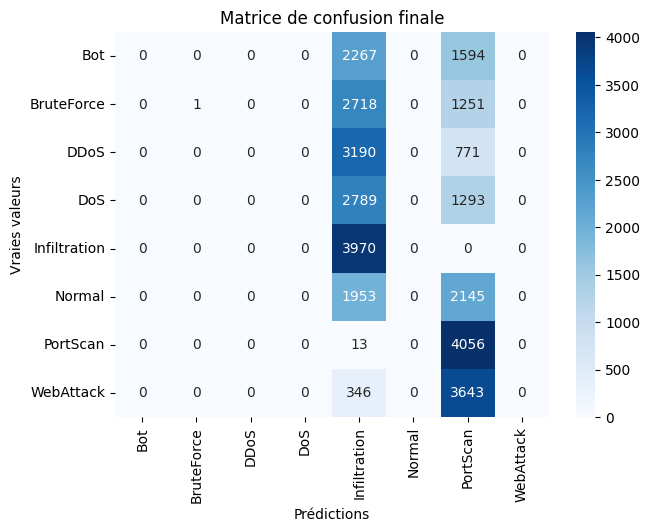

In [21]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_tensor.numpy(), y_pred.numpy())

# Affichage de la matrice de confusion
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion finale')
plt.show()

On observe un phénomène de saturation des sorties sigmoïdes. Se produit lorsque les valeurs d'entrée d'une fonction sigmoïde deviennent très grandes (positives ou négatives). Dans ces cas, les gradients (dérivées) de la fonction sigmoïde deviennent très proches de zéro, ce qui pose un problème pour l'apprentissage dans un réseau de neurones.

Les classes comme BruteForce et PortScan ont des performances significatives en termes de rappel, mais de nombreuses autres classes, comme Bot, DDoS, et WebAttack,
ont des scores de 0 pour toutes les métriques. 

**Conclusion** : Il ne faut pas utiliser la fonction d'activation Sigmoid entre les couches lorsque nos données sont peu équilibrées et qu'on joue avec de grandes valeurs !

Plusieurs méthodes d’amélioration seraient envisageables sur le modèle :
- Augmenter la taille des données pour les classes minoritaires
- Essayer une autre architecture de modèle, comme un CNN ou transformer-based model, qui pourrait
mieux capturer les patterns complexes
- Ajuster davantage les hyperparamètres du modèle, comme les taux d’apprentissage ou les fonctions
d’activation